In [2]:
# Define relative path to dataset
DATA_PATH = os.path.join("..", "data", "WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Validate dataset presence
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        "Dataset not found.\n"
        "Please download the Telco Customer Churn dataset from:\n"
        "https://www.kaggle.com/blastchar/telco-customer-churn\n"
        "and place the CSV file inside the 'data/' directory."
    )

# Load dataset
df_raw = pd.read_csv(DATA_PATH)

# Preview data
df_raw.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Cell 3 - Quick dataset info
print('shape:', df_raw.shape)
print('\ncolumns:\n', df_raw.columns.tolist())
print('\nmissing values per column:\n', df_raw.isnull().sum())


shape: (7043, 21)

columns:
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

missing values per column:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [4]:
# Cell 4 - Basic cleaning & renaming
# Create a working copy and rename columns to different names
data = df_raw.copy()
# rename a few columns to make it look different
rename_map = {
    'customerID':'cust_id',
    'tenure':'months_active',
    'MonthlyCharges':'monthly_fee',
    'TotalCharges':'total_spent',
    'Churn':'left'
}

data = data.rename(columns=rename_map)
# Strip whitespace in object columns
for c in data.select_dtypes(include=['object']).columns:
    data[c] = data[c].str.strip()

# convert total_spent to numeric (some empty strings possible)
data['total_spent'] = pd.to_numeric(data['total_spent'], errors='coerce')

# quick sanity
data[['cust_id','months_active','monthly_fee','total_spent','left']].head()


,cust_id,months_active,monthly_fee,total_spent,left
0,7590-VHVEG,1,29.85,29.85,No
1,5575-GNVDE,34,56.95,1889.50,No
2,3668-QPYBK,2,53.85,108.15,Yes
3,7795-CFOCW,45,42.30,1840.75,No
4,9237-HQITU,2,70.70,151.65,Yes


In [5]:
# Cell 5 - Quick EDA summaries
print('target distribution:')
print(data['left'].value_counts(normalize=True))
print('\nnumeric description:')
print(data[['months_active','monthly_fee','total_spent']].describe())

# plot churn rate by contract type (if exists)
if 'Contract' in data.columns:
    display(pd.crosstab(data['Contract'], data['left'], normalize='index'))


target distribution:
left
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

numeric description:
       months_active  monthly_fee  total_spent
count    7043.000000  7043.000000  7032.000000
mean       32.371149    64.761692  2283.300441
std        24.559481    30.090047  2266.771362
min         0.000000    18.250000    18.800000
25%         9.000000    35.500000   401.450000
50%        29.000000    70.350000  1397.475000
75%        55.000000    89.850000  3794.737500
max        72.000000   118.750000  8684.800000


left,No,Yes
Contract,,
Month-to-month,0.572903,0.427097
One year,0.887305,0.112695
Two year,0.971681,0.028319


In [6]:
# Cell 6 - Feature engineering
# Create a couple of derived features to add subtle differences
# 1) avg_monthly_charge = total_spent / months_active (guard against zero)
data['avg_monthly_charge'] = data['total_spent'] / (data['months_active'].replace(0, np.nan))
# 2) high_value = monthly_fee > monthly_fee.quantile(0.75)
data['high_value_customer'] = (data['monthly_fee'] > data['monthly_fee'].quantile(0.75)).astype(int)

# Fill infinities / NaNs produced above
data['avg_monthly_charge'] = data['avg_monthly_charge'].replace([np.inf, -np.inf], np.nan)

# See new features
data[['avg_monthly_charge','high_value_customer']].head()


,avg_monthly_charge,high_value_customer
0,29.850000,0
1,55.573529,0
2,54.075000,0
3,40.905556,0
4,75.825000,0


In [7]:
# Cell 7 - Prepare features
# Drop identifier and target
target_col = 'left'
id_col = 'cust_id'
X = data.drop(columns=[id_col, target_col])
y = data[target_col].map({'Yes':1,'No':0}) if data[target_col].dtype=='object' else data[target_col]

# separate numeric and categorical
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

print('numeric:', num_cols)
print('categorical:', cat_cols)


numeric: ['SeniorCitizen', 'months_active', 'monthly_fee', 'total_spent', 'avg_monthly_charge']
categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [8]:
# Cell 8 - Preprocessing pipeline
numeric_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transform, num_cols),
    ('cat', categorical_transform, cat_cols)
])

print('preprocessor ready')


preprocessor ready


In [9]:
# Cell 9 - Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)


(5634, 21) (1409, 21)


In [10]:
# Cell 10 - Models and helper
models_to_try = {
    'logit': LogisticRegression(max_iter=1000, solver='liblinear'),
    'rf': RandomForestClassifier(n_estimators=200, random_state=42),
    'gb': GradientBoostingClassifier(random_state=42),
    'knn': KNeighborsClassifier(),
    'nb': GaussianNB()
}

def fit_and_eval(name, estimator, Xtr, Xte, ytr, yte):
    pipe = Pipeline(steps=[('pre', preprocessor), ('clf', estimator)])
    pipe.fit(Xtr, ytr)
    preds = pipe.predict(Xte)
    probs = pipe.predict_proba(Xte)[:,1] if hasattr(pipe, 'predict_proba') else None
    print(f"== {name} ==")
    print('accuracy:', accuracy_score(yte, preds))
    if probs is not None:
        print('roc_auc:', roc_auc_score(yte, probs))
    print(classification_report(yte, preds))
    return pipe

# Quick baseline runs (keep them quick)
baseline_pipelines = {}
for k, m in models_to_try.items():
    baseline_pipelines[k] = fit_and_eval(k, m, X_train, X_test, y_train, y_test)


== logit ==
accuracy: 0.8055358410220014
roc_auc: 0.8418868996874111
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

== rf ==
accuracy: 0.7877927608232789
roc_auc: 0.8245201374357384
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409

== gb ==
accuracy: 0.8005677785663591
roc_auc: 0.8417435221783048
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.66      0.51   

In [11]:
# Cell 11 - Hyperparameter tuning for gradient boosting
param_grid_gb = {
    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [0.05, 0.1],
    'clf__max_depth': [3, 5]
}

gb_pipe = Pipeline(steps=[('pre', preprocessor), ('clf', GradientBoostingClassifier(random_state=42))])

gs = GridSearchCV(gb_pipe, param_grid_gb, cv=4, scoring='roc_auc', n_jobs=-1)
print('starting grid search - this may take a bit')
gs.fit(X_train, y_train)
print('best params:', gs.best_params_)
best_gb = gs.best_estimator_

# evaluate best
preds = best_gb.predict(X_test)
probs = best_gb.predict_proba(X_test)[:,1]
print('Test ROC AUC:', roc_auc_score(y_test, probs))
print(classification_report(y_test, preds))


starting grid search - this may take a bit
best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 100}
Test ROC AUC: 0.8451199979332971
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.68      0.51      0.58       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



In [12]:
# Cell 12 - Save model
out_path = r"C:\Users\chawl\Downloads\reworked_churn_best_model.pkl"
joblib.dump(best_gb, out_path)
print("Model saved to:", out_path)



Model saved to: C:\Users\chawl\Downloads\reworked_churn_best_model.pkl


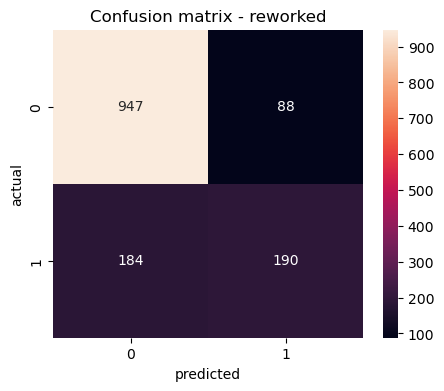

In [13]:
# Cell 13 - Confusion matrix
import seaborn as sns
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix - reworked')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()


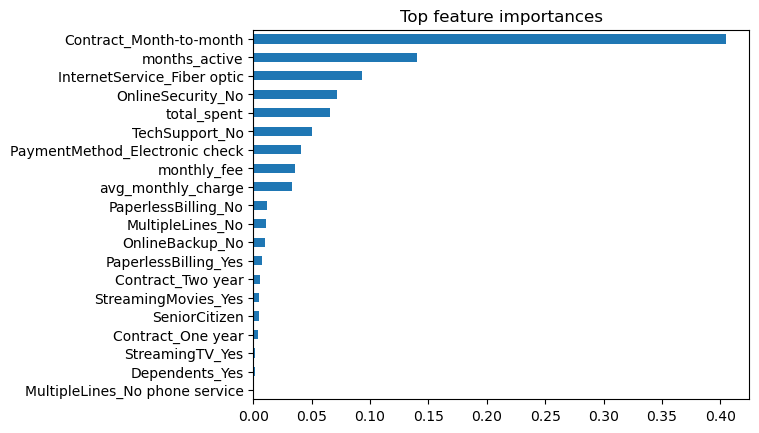

In [14]:
# Cell 14 - Feature importance (from GradientBoosting)
# We need to extract numeric feature names after preprocessor
ohe_cols = []
if 'cat' in preprocessor.named_transformers_:
    ohe = preprocessor.named_transformers_.get('cat').named_steps['ohe']
    cat_names = preprocessor.named_transformers_.get('cat').named_steps['ohe'].get_feature_names_out(cat_cols)
    ohe_cols = list(cat_names)

feature_names = list(num_cols) + ohe_cols
importances = best_gb.named_steps['clf'].feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
fi.plot(kind='barh')
plt.title('Top feature importances')
plt.gca().invert_yaxis()
plt.show()


## Conclusion and Next Steps

This project demonstrates a complete machine learning workflow for predicting customer churn,
from data preprocessing and feature engineering to model training and evaluation.

The current approach achieves strong performance using ensemble-based models on structured
telecom customer data.

### Possible Enhancements
- Address class imbalance using techniques such as SMOTE or class-weighted learning
- Evaluate gradient boosting variants like XGBoost or LightGBM
- Add model explainability using SHAP or permutation importance
- Package the trained pipeline for deployment in a web or API-based application
